<a href="https://colab.research.google.com/github/manashpratim/Tweet-Classification/blob/master/Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Downloading the Datasets
!wget --no-check-certificate \
      "https://datahack-prod.s3.amazonaws.com/train_file/train_E6oV3lV.csv"\
      -O "/tmp/train_tweets.csv"

!wget --no-check-certificate \
      "https://datahack-prod.s3.amazonaws.com/test_file/test_tweets_anuFYb8.csv"\
      -O "/tmp/test_tweets.csv"

--2019-07-10 02:04:27--  https://datahack-prod.s3.amazonaws.com/train_file/train_E6oV3lV.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.32
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103165 (3.0M) [text/csv]
Saving to: ‘/tmp/train_tweets.csv’

/tmp/train_tweets.c 100%[===================>]   2.96M  1.71MB/s    in 1.7s    

2019-07-10 02:04:30 (1.71 MB/s) - ‘/tmp/train_tweets.csv’ saved [3103165/3103165]

--2019-07-10 02:04:36--  https://datahack-prod.s3.amazonaws.com/test_file/test_tweets_anuFYb8.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.0
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1635543 (1.6M) [text/csv]
Saving to: ‘/tmp/test_tweets.csv’

/tmp/test_twee

In [0]:
import numpy as np
import pandas as pd
df1=pd.read_csv('/tmp/train_tweets.csv')
df2=pd.read_csv('/tmp/test_tweets.csv')

In [3]:
df1.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Labels Distribution:
 0    29720
1     2242
Name: label, dtype: int64


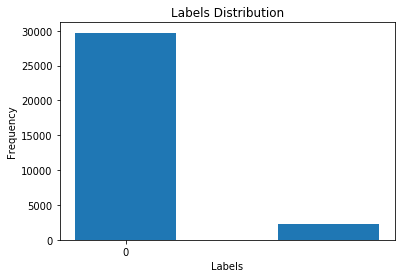

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.bar([0,1], df1['label'].value_counts(), width=0.5, bottom=None, align='center', data=df1)
plt.title('Labels Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1, step=2))
print('Labels Distribution:\n',df1['label'].value_counts())

# **Clearly this is an imbalanced dataset.**

In [115]:
#Functions for Preprocessing the Dataset
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
from textblob import Word
nltk.download('wordnet')

def mystopwords(text):
    return ' '.join([w for w in word_tokenize(text) if not w in stop_words])

def lemmatize(text):
    return ' '.join([Word(word).lemmatize() for word in text.split()])

import re
def clean_text(string):
  clean=re.sub('@[a-zA-Z0-9_]+', '', string) #removing usernames from tweets
  clean=re.sub('[\n]',' ',clean) #remove newline character
  clean=re.sub('[^a-zA-Z\']',' ',clean) #remove non alphabetic characters
  #clean=mystopwords(clean) #remove stopwords
  #clean=lemmatize(clean)
  clean=' '.join(clean.split()) #removing unnecessary spaces
  return clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#Cleaning the train data and separating the texts and labels
tweets=[]
labels=[]
for i in range(len(df1)):
  labels.append(df1['label'][i])
  tweets.append(clean_text(df1['tweet'][i]))
  
#Cleaning the test data 
test_tweets=[]
for i in range(len(df2)):
  test_tweets.append(clean_text(df2['tweet'][i]))


In [117]:
#Example of a tweet before and after cleaning
print('Tweet before cleaning: ',df1['tweet'][1])
print('Tweet after cleaning: ',tweets[1])

Tweet before cleaning:  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
Tweet after cleaning:  thanks for lyft credit i can't use cause they don't offer wheelchair vans in pdx disapointed getthanked


Text(0.5, 1.0, 'Top 100 Words in the Hate Tweets')

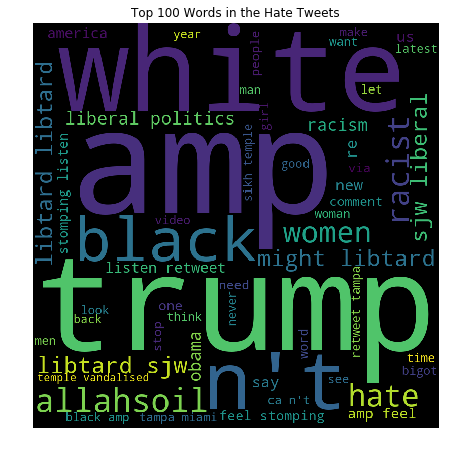

In [118]:
#Word Cloud of Top 100 Words in Hate Tweets 
from wordcloud import WordCloud, STOPWORDS  
hate=[]
for i in range(len(tweets)): #getting the hate tweets
  if labels[i]==1:
    hate.append(tweets[i])
h=' '.join(hate)  #transforming the list of hate tweets into a single sentence
h=mystopwords(h)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 20,max_words=100).generate(h)
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Top 100 Words in the Hate Tweets')

In [0]:
#Suffling the data and splitting the data into train and test sets (90:10)
from sklearn.model_selection import train_test_split
train_tweets, val_tweets, train_labels, val_labels= train_test_split(tweets, labels, test_size=0.1, shuffle= True,random_state=42)

In [120]:
#Data Summary
print('Length of the Training Set: ',len(df1))
print('No. of Training Examples: ',len(train_tweets))
print('No. of Validation Examples: ',len(val_tweets))
print('No. of Test Examples: ',len(test_tweets))

Length of the Training Set:  31962
No. of Training Examples:  28765
No. of Validation Examples:  3197
No. of Test Examples:  17197


In [121]:
#Tokenization and Padding
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#embedding_dim = 200
max_length = 40
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_len=49999

tokenizer = Tokenizer(num_words=vocab_len+1,oov_token=oov_tok)
tokenizer.fit_on_texts(tweets)

word_index = tokenizer.word_index
vocab_size=len(word_index)
print('Size of Vocabulary: ',vocab_size)

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_tweets)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_tweets)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_labels=np.expand_dims(train_labels, axis=1)
val_labels=np.expand_dims(val_labels, axis=1)

Size of Vocabulary:  38363


In [122]:
#Dimension of Data after Tokenizing and Padding
print('Dimension of Training Data: ',train_padded.shape)
print('Dimension of Validation Data: ',val_padded.shape)
print('Dimension of Training Labels: ',train_labels.shape)
print('Dimension of Validation Labels: ',val_labels.shape)
print('Dimension of Test Data: ',test_padded.shape)

Dimension of Training Data:  (28765, 40)
Dimension of Validation Data:  (3197, 40)
Dimension of Training Labels:  (28765, 1)
Dimension of Validation Labels:  (3197, 1)
Dimension of Test Data:  (17197, 40)


In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Unzipping the fasttext pretrained model from Google Drive
import os
import zipfile

#local_zip='/content/drive/My Drive/glove.twitter.27B.zip'
#local_zip='/content/drive/My Drive/crawl-300d-2M.vec.zip'
#local_zip='/content/drive/My Drive/glove.6B.zip'
local_zip='/content/drive/My Drive/wiki-news-300d-1M.vec.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/drive/My Drive/wiki-news-300d-1M.vec')
zip_ref.close()

In [0]:
# Loading the pretrained vectors
embeddings_index1 = {}
embeddings_index2 = {}
embeddings_index3 = {}
embeddings_index4 = {}

import numpy as np
with open('/content/drive/My Drive/glove.twitter.27B/glove.twitter.27B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index1[word] = coefs

with open('/content/drive/My Drive/crawl-300d-2M.vec/crawl-300d-2M.vec') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index2[word] = coefs

with open('/content/drive/My Drive/glove.6B/glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index3[word] = coefs

In [126]:
#Creating an embedding matrix that contains the vectors of the words in the dataset
embedding_dim1=200
embedding_dim=300

embeddings_matrix1 = np.zeros((vocab_size, embedding_dim1))
for word, i in word_index.items():
    embedding_vector = embeddings_index1.get(word)
    if embedding_vector is not None:
        embeddings_matrix1[i] = embedding_vector
        
        
embeddings_matrix2 = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index2.get(word)
    if embedding_vector is not None:
        embeddings_matrix2[i] = embedding_vector

embeddings_matrix3 = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index3.get(word)
    if embedding_vector is not None:
        embeddings_matrix3[i] = embedding_vector
        

'embeddings_matrix3 = np.zeros((vocab_size+1, embedding_dim))\nfor word, i in word_index.items():\n    embedding_vector = embeddings_index3.get(word)\n    if embedding_vector is not None:\n        embeddings_matrix3[i] = embedding_vector\n        \nembeddings_matrix4 = np.zeros((vocab_size, embedding_dim))\nfor word, i in word_index.items():\n    embedding_vector = embeddings_index4.get(word)\n    if embedding_vector is not None:\n        embeddings_matrix4[i] = embedding_vector'

In [127]:
print('Shape of the Embeddings Matrix (GloVe Twitter): ',embeddings_matrix1.shape)
print('Shape of the Embeddings Matrix (fastText Crawl): ',embeddings_matrix2.shape)
print('Shape of the Embeddings Matrix (GloVe Wiki): ',embeddings_matrix3.shape)

Shape of the Embeddings Matrix (GloVe Twitter):  (38363, 200)
Shape of the Embeddings Matrix (fastText Crawl):  (38363, 300)
Shape of the Embeddings Matrix (GloVe Wiki):  (38364, 300)
Shape of the Embeddings Matrix (fastText WikiNews):  (38363, 300)


## **Building the model using GloVe (Twitter) pretrained embeddings**

In [0]:
model1_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim1, input_length=max_length, weights = [embeddings_matrix1], trainable = False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [132]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model1_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 10
history1=model1_lstm.fit(train_padded, 
                    train_labels, 
                    epochs=num_epochs, 
                    batch_size=256, 
                    validation_data=(val_padded,val_labels),
                    callbacks=[reduce],
                    verbose=1)

Train on 28765 samples, validate on 3197 samples
Epoch 1/10
28765/28765 [==============================] - 11s 397us/sample - loss: 0.2180 - acc: 0.9298 - val_loss: 0.1349 - val_acc: 0.9484
Epoch 2/10
28765/28765 [==============================] - 8s 272us/sample - loss: 0.1538 - acc: 0.9465 - val_loss: 0.1281 - val_acc: 0.9525
Epoch 3/10
28765/28765 [==============================] - 8s 273us/sample - loss: 0.1407 - acc: 0.9495 - val_loss: 0.1331 - val_acc: 0.9528
Epoch 4/10
28765/28765 [==============================] - 8s 274us/sample - loss: 0.1319 - acc: 0.9541 - val_loss: 0.1158 - val_acc: 0.9543
Epoch 5/10
28765/28765 [==============================] - 8s 274us/sample - loss: 0.1237 - acc: 0.9559 - val_loss: 0.1103 - val_acc: 0.9562
Epoch 6/10
28765/28765 [==============================] - 8s 274us/sample - loss: 0.1123 - acc: 0.9595 - val_loss: 0.1092 - val_acc: 0.9578
Epoch 7/10
28765/28765 [==============================] - 8s 274us/sample - loss: 0.1079 - acc: 0.9621 - val_l

In [133]:
#Determining the optimal threshold value to seggregate the classes
pred1= model1_lstm.predict(val_padded, batch_size=256,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred1>thresh).astype(int))))

3197/3197 [==============================] - 1s 319us/sample
F1 score at threshold 0.1 is 0.6371681415929203
F1 score at threshold 0.11 is 0.6484517304189436
F1 score at threshold 0.12 is 0.6579925650557621
F1 score at threshold 0.13 is 0.6629001883239172
F1 score at threshold 0.14 is 0.6717557251908397
F1 score at threshold 0.15 is 0.6705202312138728
F1 score at threshold 0.16 is 0.6784313725490195
F1 score at threshold 0.17 is 0.6798418972332015
F1 score at threshold 0.18 is 0.68389662027833
F1 score at threshold 0.19 is 0.6829268292682926
F1 score at threshold 0.2 is 0.6748971193415637
F1 score at threshold 0.21 is 0.6804979253112032
F1 score at threshold 0.22 is 0.6919831223628692
F1 score at threshold 0.23 is 0.6950959488272921
F1 score at threshold 0.24 is 0.6995708154506439
F1 score at threshold 0.25 is 0.7012987012987013
F1 score at threshold 0.26 is 0.7002188183807438
F1 score at threshold 0.27 is 0.70509977827051
F1 score at threshold 0.28 is 0.701123595505618
F1 score at thr

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2984
           1       0.78      0.67      0.72       213

    accuracy                           0.97      3197
   macro avg       0.88      0.83      0.85      3197
weighted avg       0.96      0.97      0.96      3197

[[2943   41]
 [  70  143]]


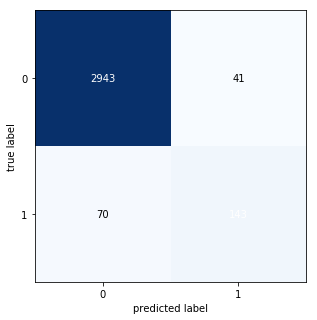

In [134]:
#From above, we can see that F1 score is highest at a threshold of 0.4
pred_val_labels1=(pred1>0.4).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_val_labels1))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_val_labels1))
CM = confusion_matrix(val_labels, pred_val_labels1)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()
  

## **Building the model using fastText (Common Crawl) pretrained embeddings**

In [0]:
model2_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim2, input_length=max_length, weights = [embeddings_matrix2], trainable = False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [137]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model2_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 10
history2=model2_lstm.fit(train_padded, 
                    train_labels, 
                    epochs=num_epochs, 
                    batch_size=256, 
                    validation_data=(val_padded,val_labels),
                    callbacks=[reduce],
                    verbose=1)

Train on 28765 samples, validate on 3197 samples
Epoch 1/10
28765/28765 [==============================] - 12s 423us/sample - loss: 0.2009 - acc: 0.9331 - val_loss: 0.1310 - val_acc: 0.9478
Epoch 2/10
28765/28765 [==============================] - 8s 284us/sample - loss: 0.1421 - acc: 0.9508 - val_loss: 0.1266 - val_acc: 0.9540
Epoch 3/10
28765/28765 [==============================] - 8s 286us/sample - loss: 0.1339 - acc: 0.9524 - val_loss: 0.1203 - val_acc: 0.9578
Epoch 4/10
28765/28765 [==============================] - 8s 284us/sample - loss: 0.1238 - acc: 0.9560 - val_loss: 0.1115 - val_acc: 0.9603
Epoch 5/10
28765/28765 [==============================] - 8s 287us/sample - loss: 0.1165 - acc: 0.9586 - val_loss: 0.1077 - val_acc: 0.9603
Epoch 6/10
28765/28765 [==============================] - 8s 284us/sample - loss: 0.1096 - acc: 0.9602 - val_loss: 0.1066 - val_acc: 0.9606
Epoch 7/10
28765/28765 [==============================] - 8s 285us/sample - loss: 0.1019 - acc: 0.9634 - val_l

In [138]:
#Determining the optimal threshold value to seggregate the classes
pred2= model2_lstm.predict(val_padded, batch_size=256,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred2>thresh).astype(int))))

3197/3197 [==============================] - 1s 354us/sample
F1 score at threshold 0.1 is 0.6679536679536681
F1 score at threshold 0.11 is 0.6758349705304518
F1 score at threshold 0.12 is 0.68
F1 score at threshold 0.13 is 0.686868686868687
F1 score at threshold 0.14 is 0.6995884773662552
F1 score at threshold 0.15 is 0.7112970711297072
F1 score at threshold 0.16 is 0.7091295116772823
F1 score at threshold 0.17 is 0.7109207708779444
F1 score at threshold 0.18 is 0.712742980561555
F1 score at threshold 0.19 is 0.7076923076923077
F1 score at threshold 0.2 is 0.7035398230088497
F1 score at threshold 0.21 is 0.7085201793721975
F1 score at threshold 0.22 is 0.7165532879818594
F1 score at threshold 0.23 is 0.7123287671232877
F1 score at threshold 0.24 is 0.7139588100686498
F1 score at threshold 0.25 is 0.7146171693735499
F1 score at threshold 0.26 is 0.7132867132867133
F1 score at threshold 0.27 is 0.7058823529411764
F1 score at threshold 0.28 is 0.7092198581560283
F1 score at threshold 0.29

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2984
           1       0.81      0.66      0.73       213

    accuracy                           0.97      3197
   macro avg       0.89      0.82      0.85      3197
weighted avg       0.96      0.97      0.97      3197

[[2951   33]
 [  73  140]]


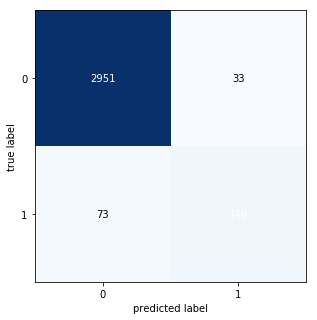

In [139]:
pred_val_labels2=(pred2>0.42).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_val_labels2))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_val_labels2))
CM = confusion_matrix(val_labels, pred_val_labels2)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()
  

## **Building the model using GloVe(Wiki) pretrained embeddings**

In [0]:
model3_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights = [embeddings_matrix3], trainable = False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [144]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model3_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 10
history3=model3_lstm.fit(train_padded, 
                    train_labels, 
                    epochs=num_epochs, 
                    batch_size=256, 
                    validation_data=(val_padded,val_labels),
                    callbacks=[reduce],
                    verbose=1)

Train on 28765 samples, validate on 3197 samples
Epoch 1/10
28765/28765 [==============================] - 12s 432us/sample - loss: 0.2159 - acc: 0.9323 - val_loss: 0.1414 - val_acc: 0.9462
Epoch 2/10
28765/28765 [==============================] - 8s 288us/sample - loss: 0.1523 - acc: 0.9463 - val_loss: 0.1294 - val_acc: 0.9537
Epoch 3/10
28765/28765 [==============================] - 8s 289us/sample - loss: 0.1406 - acc: 0.9515 - val_loss: 0.1241 - val_acc: 0.9546
Epoch 4/10
28765/28765 [==============================] - 8s 290us/sample - loss: 0.1275 - acc: 0.9548 - val_loss: 0.1266 - val_acc: 0.9565
Epoch 5/10
28765/28765 [==============================] - 8s 289us/sample - loss: 0.1202 - acc: 0.9587 - val_loss: 0.1140 - val_acc: 0.9593
Epoch 6/10
28765/28765 [==============================] - 8s 289us/sample - loss: 0.1099 - acc: 0.9610 - val_loss: 0.1217 - val_acc: 0.9615
Epoch 7/10
28765/28765 [==============================] - 8s 290us/sample - loss: 0.1050 - acc: 0.9639 - val_l

In [145]:
#Determining the optimal threshold value to seggregate the classes
pred3= model3_lstm.predict(val_padded, batch_size=256,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred3>thresh).astype(int))))

3197/3197 [==============================] - 1s 320us/sample
F1 score at threshold 0.1 is 0.5826513911620295
F1 score at threshold 0.11 is 0.5906040268456376
F1 score at threshold 0.12 is 0.5996592844974447
F1 score at threshold 0.13 is 0.6151142355008787
F1 score at threshold 0.14 is 0.6227758007117438
F1 score at threshold 0.15 is 0.6327272727272726
F1 score at threshold 0.16 is 0.6408839779005525
F1 score at threshold 0.17 is 0.6641221374045801
F1 score at threshold 0.18 is 0.6796875
F1 score at threshold 0.19 is 0.6850393700787402
F1 score at threshold 0.2 is 0.68937875751503
F1 score at threshold 0.21 is 0.6829268292682926
F1 score at threshold 0.22 is 0.6871165644171779
F1 score at threshold 0.23 is 0.6861924686192469
F1 score at threshold 0.24 is 0.690677966101695
F1 score at threshold 0.25 is 0.6909871244635193
F1 score at threshold 0.26 is 0.69281045751634
F1 score at threshold 0.27 is 0.6916299559471365
F1 score at threshold 0.28 is 0.6948775055679288
F1 score at threshold 0.

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2984
           1       0.77      0.70      0.73       213

    accuracy                           0.97      3197
   macro avg       0.88      0.84      0.86      3197
weighted avg       0.96      0.97      0.97      3197

[[2940   44]
 [  64  149]]


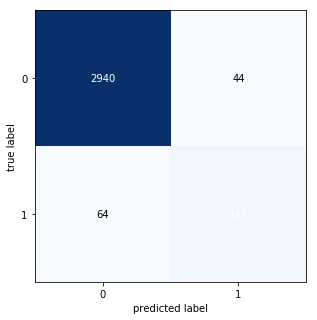

In [146]:
pred_val_labels3=(pred3>0.45).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_val_labels3))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_val_labels3))
CM = confusion_matrix(val_labels, pred_val_labels3)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

##**Ensemble Model**

In [164]:
pred1_l = model1_lstm.predict(val_padded, batch_size=256,verbose=1)
pred2_l = model2_lstm.predict(val_padded, batch_size=256,verbose=1)
pred3_1 = model3_lstm.predict(val_padded, batch_size=256,verbose=1)
pred_val = 0.5*pred1_l + 0.25*pred2_l + 0.25*pred3_1

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred_val>thresh).astype(int))))

3197/3197 [==============================] - 0s 90us/sample
F1 score at threshold 0.1 is 0.6506849315068494
F1 score at threshold 0.11 is 0.658493870402802
F1 score at threshold 0.12 is 0.6583184257602862
F1 score at threshold 0.13 is 0.6715328467153285
F1 score at threshold 0.14 is 0.6728971962616822
F1 score at threshold 0.15 is 0.6793893129770993
F1 score at threshold 0.16 is 0.6820809248554914
F1 score at threshold 0.17 is 0.683794466403162
F1 score at threshold 0.18 is 0.6975806451612904
F1 score at threshold 0.19 is 0.7063655030800821
F1 score at threshold 0.2 is 0.7136929460580912
F1 score at threshold 0.21 is 0.7200000000000001
F1 score at threshold 0.22 is 0.7215189873417721
F1 score at threshold 0.23 is 0.7237687366167024
F1 score at threshold 0.24 is 0.7331887201735359
F1 score at threshold 0.25 is 0.7352297592997812
F1 score at threshold 0.26 is 0.7340659340659341
F1 score at threshold 0.27 is 0.734966592427617
F1 score at threshold 0.28 is 0.7449209932279909
F1 score at th

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2984
           1       0.77      0.75      0.76       213

    accuracy                           0.97      3197
   macro avg       0.88      0.87      0.87      3197
weighted avg       0.97      0.97      0.97      3197

[[2936   48]
 [  53  160]]


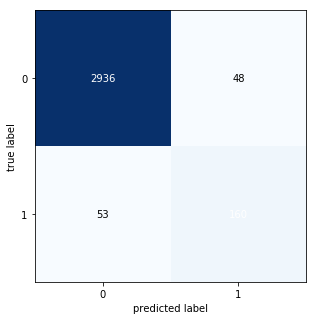

In [156]:
pred_val_labels=(pred_val>0.33).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_val_labels))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_val_labels))
CM = confusion_matrix(val_labels, pred_val_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

##**Ensemble Model gives the best F1 Score**

In [153]:
pred_test1 = model1_lstm.predict(test_padded, batch_size=256,verbose=1)
pred_test2 = model2_lstm.predict(test_padded, batch_size=256,verbose=1)
pred_test3 = model3_lstm.predict(test_padded, batch_size=256,verbose=1)
pred_test = 0.5*pred_test1 + 0.25*pred_test2 + 0.25*pred_test3 
pred_test_labels = (pred_test>0.33).astype(int)
out_df = pd.DataFrame({'id':df2['id'].values})
out_df['label'] = pred_test_labels
out_df.to_csv('submission.csv', index=False)

17197/17197 [==============================] - 2s 89us/sample
